In [1]:
from astropy.io import ascii
import pylab as plt
%matplotlib inline

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d

import pystan
import numpy as np

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
class FilterDefinition:
    def __init__(self):
        """
        Placeholder for the filter definition information.
        """
        self.name = None
        self.wavelength = None
        self.transmision = None

class FilterFile:
    def __init__(self, file='FILTER.RES.v8.R300'):
        """
        Read a EAZY (HYPERZ) filter file.
        """
        fp = open(file)
        lines = fp.readlines()
        fp.close()
        
        filters = []
        wave = []
        for line in lines:
            try:
                lspl = np.cast[float](line.split())
                wave.append(lspl[1])
                trans.append(lspl[2])
            except (ValueError,IndexError):
                if len(wave) > 0:
                    new_filter = FilterDefinition()
                    new_filter.name = header
                    new_filter.wavelength = np.cast[float](wave)
                    new_filter.transmission = np.cast[float](trans)
                    filters.append(new_filter)
                    
                header = ' '.join(line.split()[1:])
                wave = []
                trans = []
        # last one
        new_filter = FilterDefinition()
        new_filter.name = header
        new_filter.wavelength = np.cast[float](wave)
        new_filter.transmission = np.cast[float](trans)
        filters.append(new_filter)
           
        self.filters = filters
        self.NFILT = len(filters)
    
    def names(self):
        """
        Print the filter names.
        """
        for i in range(len(self.filters)):
            print '%5d %s' %(i+1, self.filters[i].name)
    
    def write(self, file='xxx.res', verbose=True):
        """
        Dump the filter information to a filter file.
        """
        fp = open(file,'w')
        for filter in self.filters:
            fp.write('%6d %s\n' %(len(filter.wavelength), filter.name))
            for i in range(len(filter.wavelength)):
                fp.write('%-6d %.5e %.5e\n' %(i+1, filter.wavelength[i], filter.transmission[i]))
        
        fp.close()
        if verbose:
            print 'Wrote <%s>.' %(file)
            
    def search(self, search_string, case=True, verbose=True):
        """ 
        Search filter names for `search_string`.  If `case` is True, then
        match case.
        """
        import re
        
        if not case:
            search_string = search_string.upper()
        
        matched = []
        
        for i in range(len(self.filters)):
            filt_name = self.filters[i].name
            if not case:
                filt_name = filt_name.upper()
                
            if re.search(search_string, filt_name) is not None:
                if verbose:
                    print '%5d %s' %(i+1, self.filters[i].name)
                matched.append(i)
        
        return np.array(matched)

In [3]:
filter=FilterFile(file="/Users/pdh21/astrodata/COSMOS/WP5_COSMOS_XIDplus_P2/filters.res")

In [4]:
SPIRE_250=filter.filters[215]
SPIRE_350=filter.filters[216]
SPIRE_500=filter.filters[217]

In [5]:
def fnu_filt(sed_fnu,filt_nu,filt_trans,nu_0,sed_f0):
    #f_nu=Int(d_nu f_nu R_nu)/Int(d_nu (nu/nu_0)^-1 R_nu)
    numerator=np.trapz(sed_fnu*filt_trans,x=filt_nu)
    denominator=np.trapz(filt_trans*(nu_0/filt_nu),x=filt_nu)
    
    #colour correction
    #C=Int(d_nu (nu/nu_0)^-1 R_nu)/Int(d_nu (f(nu)/f(nu_0)) R_nu)
    C_num=np.trapz(filt_trans*(nu_0/filt_nu),x=filt_nu)
    C_denom=np.trapz(filt_trans*(sed_fnu/sed_f0),x=filt_nu)

    
    return (numerator/denominator)*(C_num/C_denom)


In [6]:
import os
temps=os.listdir('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/')


I need to create a redshift pdf, ideally with reasonable spacings in wavelength space. Since the greatest change in wavelength comes at lower redshift, it seems appropriate to have increase intervals in redshift pdf as a function of redshift. Below shows derivation of how to get equal spacing in wavelength as a function of redshift for the three SPIRE bands: 
+ $\lambda_{emitt}=\frac{\lambda_{obs.}}{1+z}$
+ $\mathrm{d}\lambda_{emitt}=-\frac{\lambda_{obs.}}{(1+z)^2}\mathrm{d}z$
+ $\mathrm{d}z=\frac{\mathrm{d}\lambda_{emitt}}{\lambda_{obs.}}(1+z)^2$
+ where $\mathrm{d}\lambda_{emitt}=(\frac{\lambda_{obs.}}{1+z_{low}} - \frac{\lambda_{obs.}}{1+z_{up}})/\mathrm{no.points}$
+ $\mathrm{d}\lambda_{emitt}=\lambda_{obs.}(1-\frac{1}{z_{up}+1})/\mathrm{no.points}$
+ $\mathrm{d}z=(1+z)^2(1-\frac{1}{z_{up}+1})/\mathrm{no.points}$

In order to add prior using redshift and colour, where redshift is in discrete bins, I need to marginalise out redshift and SED type:

$p(S_{250},S_{350},S_{500})=\sum_{i=1}^{\infty} 

In [7]:
import numpy as np
n_p=20
z_l=7

red=np.zeros(n_p)
lambda_emit=np.empty(n_p*3.0)
lambda_emit[[0,n_p,n_p*2]]=[250.0,350.0,500.0]
for i in range(0,n_p-1):
    red[i+1]=red[i]+((1-1.0/(z_l+1))/n_p)*(1+red[i])**2
    lambda_emit[i+1]=250.0/(1+red[i+1])
    lambda_emit[i+1+n_p]=350.0/(1+red[i+1])
    lambda_emit[i+1+2*n_p]=500.0/(1+red[i+1])
print lambda_emit
print red
    




[ 250.          239.52095808  229.0610978   218.62205449  208.20567811
  197.81407193  187.44964021  177.11514758  166.8137934   156.54930626
  146.32606495  136.14925549  126.02507757  115.96101985  105.96623302
   96.05204428   86.23268071   76.52630846   66.95656169   57.5548515   350.
  335.32934132  320.68553692  306.07087628  291.48794935  276.9397007
  262.4294963   247.96120661  233.53931076  219.16902876  204.85649093
  190.60895768  176.4351086   162.34542779  148.35272623  134.472862
  120.72575299  107.13683184   93.73918636   80.57679209  500.
  479.04191617  458.1221956   437.24410897  416.41135621  395.62814385
  374.89928043  354.23029516  333.6275868   313.09861252  292.65212989
  272.29851097  252.05015514  231.9220397   211.93246605  192.10408857
  172.46536141  153.05261692  133.91312337  115.10970299]
[ 0.          0.04375     0.09141187  0.14352598  0.20073574  0.26381302
  0.33369154  0.41151112  0.49867703  0.59694096  0.70851311  0.8362201
  0.98373217  1.15589

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [8]:
col_berta=np.empty((3,red.size,len(temps)))

In [9]:
for i in range(0,len(temps)):
    template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[i])
    flux=template['col2']*(template['col1']**2)/3E8
    wave=template['col1']/1E4

    for z in range(0,red.size):
        sed=interp1d((red[z]+1.0)*wave, flux)
        col_berta[0,z,i]=fnu_filt(sed(SPIRE_250.wavelength/1E4),3E8/(SPIRE_250.wavelength/1E10),SPIRE_250.transmission,3E8/250E-6,sed(250.0))
        col_berta[1,z,i]=fnu_filt(sed(SPIRE_350.wavelength/1E4),3E8/(SPIRE_350.wavelength/1E10),SPIRE_350.transmission,3E8/350E-6,sed(350.0))
        col_berta[2,z,i]=fnu_filt(sed(SPIRE_500.wavelength/1E4),3E8/(SPIRE_500.wavelength/1E10),SPIRE_500.transmission,3E8/500E-6,sed(500.0))

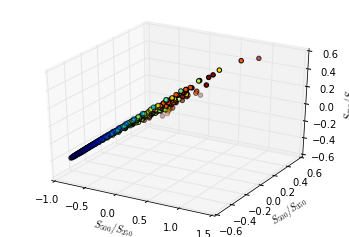

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0,len(temps)):
    ax.scatter(np.log10(col_berta[2,:,i]/col_berta[0,:,i]), np.log10(col_berta[2,:,i]/col_berta[1,:,i]), np.log10(col_berta[1,:,i]/col_berta[0,:,i]), marker='o',c=red,cmap = cm.jet)
ax.set_xlabel(r'$S_{500}/S_{250}$')
ax.set_ylabel(r'$S_{500}/S_{350}$')
ax.set_zlabel(r'$S_{350}/S_{250}$')


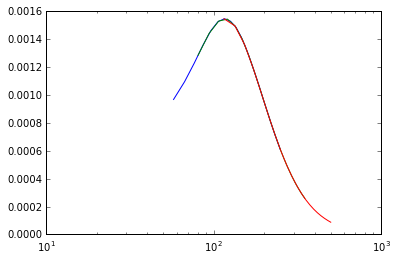

In [11]:
plt.figure()
for i in range(0,1):
    plt.plot(250/(1+red),col_berta[0,:,i])
    plt.plot(350.0/(1+red),col_berta[1,:,i])
    plt.plot(500.0/(1+red),col_berta[2,:,i])
plt.xscale('log')
#plt.yscale('log')

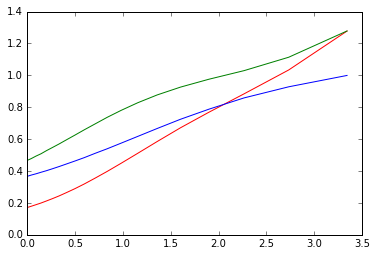

In [12]:
plt.figure()
for i in range(1,2):
    plt.plot(red,col_berta[2,:,i]/col_berta[0,:,i],'r')
    plt.plot(red,col_berta[2,:,i]/col_berta[1,:,i],'b')
    plt.plot(red,col_berta[1,:,i]/col_berta[0,:,i],'g')


In [15]:
import xidplus
from xidplus import moc_routines
import pickle
output_folder='./'

with open(output_folder+'Master_prior.pkl', "rb") as f:
        Master = pickle.load(f)

taskid=100      

tiles=Master['tiles']
order=Master['order']
prior250=Master['psw']
prior350=Master['pmw']
prior500=Master['plw']


moc=moc_routines.get_fitting_region(order,tiles[taskid-1])
prior250.set_tile(moc)
prior350.set_tile(moc)
prior500.set_tile(moc)

print 'fitting '+ str(prior250.nsrc)+' sources \n'
print 'there are '+ str(prior250.snpix)+' pixels'

prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()

print 'set prior upper limit'
prior250.flux_scale(log=False)
prior250.upper_lim_map()
prior250.lower_lim_flux(0.01)
prior350.flux_scale(log=False)
prior350.upper_lim_map()
prior350.lower_lim_flux(0.01)
prior500.flux_scale(log=False)
prior500.upper_lim_map()
prior500.lower_lim_flux(0.01)


from xidplus.stan_fit import SPIRE

fitting 147 sources 

there are 2656 pixels
set prior upper limit


In [16]:
prior250.moc.write('moc_spm_test')

### Get Redshift PDFs

In [17]:
#Folder containing prior input catalogue
folder='../../test_files/'
#prior catalogue
prior_cat='lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits'
from astropy.io import fits
hdulist = fits.open(folder+prior_cat)
fcat=hdulist[1].data
hdulist.close()
f_src=fcat['S100']
sgood=f_src >0.050
fcat=fcat[sgood]
print fcat[prior250.ID].Z_OBS

[ 0.48395455  0.48923671  0.4915365   3.08944273  1.27064252  1.27039289
  1.27494144  1.2725575   1.26527977  2.54233503  0.63894987  0.57213128
  0.42202687  2.95384145  2.94620061  3.56526327  1.8391993   2.09870195
  2.09735608  0.49115705  0.36042655  0.95647037  2.09381104  0.94688606
  2.56297803  1.15740633  0.23015809  1.82836652  0.38854992  0.48007214
  1.71931648  1.7645278   1.46449327  1.43237162  1.04472709  1.37414622
  1.21919537  1.21070242  1.95530868  2.00999451  2.45518756  2.28406453
  1.17250681  1.11058879  0.94075334  2.15101194  0.0594933   0.53791678
  3.23061037  1.04422975  1.89217901  0.74920535  1.21114516  1.20915079
  1.1944654   1.29835439  1.25594378  0.9242152   1.13551426  1.66105103
  1.66133237  1.64933038  1.33792043  1.3420856   1.34168148  1.33955479
  1.34378791  1.34445047  0.16520512  2.813591    1.20392275  0.50235999
  1.04872799  1.56883979  1.28921509  1.47172809  0.63759494  2.17386794
  1.43120456  0.16989303  0.58930981  0.26640558  0

In [18]:
from scipy.stats import truncnorm
sig=0.2
redpdf=np.zeros((prior250.nsrc,red.size))
for i in range(0,prior250.nsrc):
    rv = truncnorm(0.0,3.0,fcat[prior250.ID-1].Z_OBS[i],sig)
    redpdf[i,:-1]=rv.cdf(red[1:])-rv.cdf(red[:-1])
redpdf[redpdf<1E-5]=1E-6
redpdf=np.log(redpdf)

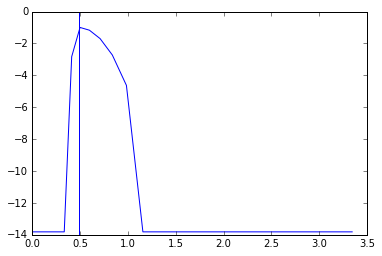

In [19]:
plt.figure()
plt.plot(red,redpdf[2,:])
plt.axvline(fcat[prior250.ID-1].Z_OBS[2])

In [20]:
SEDs=col_berta[:,:,[0,1]].reshape(3*red.size,2)

In [21]:
fit_orig=SPIRE.all_bands(prior250,prior350,prior500,chains=4,iter=1000)

/Users/pdh21/HELP/XID_plus/scripts/test_run/XID+SPIRE.pkl found. Reusing


/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr

In [22]:
from xidplus.stan_fit import SPIRE

fit=SPIRE.all_bands_SPM(prior250,prior350,prior500,redpdf,SEDs,chains=4,iter=1000)

(60, 2)
/Users/pdh21/HELP/XID_plus/scripts/test_run/XID+SED_SPM.stan.pkl found. Reusing


/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr

In [76]:
from xidplus.stan_fit import SPIRE

fit=SPIRE.all_bands_SPM_prior(prior250,prior350,prior500,redpdf,SEDs,chains=4,iter=1000)

AttributeError: 'module' object has no attribute 'all_bands_SPM_prior'

In [ ]:
prior250_noise=prior250
prior350_noise=prior350
prior500_noise=prior500
prior250_noise.snim[:]=100.0
prior350_noise.snim[:]=100.0
prior500_noise.snim[:]=100.0

fit_noise=SPIRE.all_bands_SPM(prior250_noise,prior350_noise,prior500_noise,redpdf,SEDs,chains=4,iter=1000)

In [ ]:
from scipy.stats import truncnorm
sig=0.2
redpdf=np.zeros((prior250.nsrc,red.size))
for i in range(0,prior250.nsrc):
    rv = truncnorm(0.0,3.0,np.linspace(0,3.0,num=prior250.nsrc)[i],sig)
    redpdf[i,:-1]=rv.cdf(red[1:])-rv.cdf(red[:-1])
                          
redpdf[redpdf<1E-5]=1E-6
redpdf=np.log(redpdf)

In [ ]:
print red

In [ ]:
print red
for i in [16,17,18,20,21,22]:
    plt.plot(red[:],redpdf[i,:])
    print redpdf[i,:]



In [ ]:
prior250_noise=prior250
prior350_noise=prior350
prior500_noise=prior500
prior250_noise.sim[:]=0.0
prior350_noise.sim[:]=0.0
prior500_noise.sim[:]=0.0
prior250_noise.snim[:]=1000.0
prior350_noise.snim[:]=1000.0
prior500_noise.snim[:]=1000.0

fit_noise_red=SPIRE.all_bands_SPM(prior250_noise,prior350_noise,prior500_noise,redpdf,SEDs,chains=4,iter=1000)

In [23]:
posterior=xidplus.posterior_stan(fit,[prior250,prior350,prior500])
#posterior_noise_red=xidplus.posterior_stan(fit_noise_red,[prior250_noise,prior350_noise,prior500_noise])
posterior_orig=xidplus.posterior_stan(fit_orig,[prior250,prior350,prior500])


In [ ]:
plt.figure()
plt.hist(posterior.stan_fit[:,:,39*3+2].reshape(2000,1))
plt.axvline(fcat[prior250.ID-1].S350[2])


In [24]:
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd


/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [ ]:
s=3
df = pd.DataFrame(np.log10(posterior.stan_fit[:,:,[s+(39*2),s+(39*2),s+39]].reshape(2000,3)/posterior.stan_fit[:,:,[s,s+39,s]].reshape(2000,3)),columns=[r'$S_{500}/S_{250}$',r'$S_{500}/S_{350}$',r'$S_{350}/S_{250}$'])
g = sns.PairGrid(df)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="BuPu_d", n_levels=6,alpha=0.5)
df2 = pd.DataFrame(np.log10(np.tile([fcat[prior250.ID-1].S500[s]/fcat[prior250.ID-1].S250[s],fcat[prior250.ID-1].S500[s]/fcat[prior250.ID-1].S350[s],fcat[prior250.ID-1].S350[s]/fcat[prior250.ID-1].S250[s]],(2,1))),columns=[r'$S_{500}/S_{250}$',r'$S_{500}/S_{350}$',r'$S_{350}/S_{250}$'])
g.data=df2
g.map_offdiag(plt.scatter,marker='x', c='k', s=100,alpha=1)
g.data=pd.DataFrame(np.log10(posterior_noise.stan_fit[:,:,[s+(39*2),s+(39*2),s+39]].reshape(2000,3)/posterior_noise.stan_fit[:,:,[s,s+39,s]].reshape(2000,3)),columns=[r'$S_{500}/S_{250}$',r'$S_{500}/S_{350}$',r'$S_{350}/S_{250}$'])
g.map_diag(sns.kdeplot,c='r')
g.map_offdiag(sns.kdeplot, cmap="OrRd_d", n_levels=6,alpha=0.5)
g.data=pd.DataFrame(np.log10(posterior_noise_red.stan_fit[:,:,[s+(39*2),s+(39*2),s+39]].reshape(2000,3)/posterior_noise.stan_fit[:,:,[s,s+39,s]].reshape(2000,3)),columns=[r'$S_{500}/S_{250}$',r'$S_{500}/S_{350}$',r'$S_{350}/S_{250}$'])
g.map_diag(sns.kdeplot,c='g')
g.map_offdiag(sns.kdeplot, cmap="YlGn", n_levels=6,alpha=0.5,)
g.set(ylim=(-1.5,0.5))
g.set(xlim=(-1.5,0.5))

TypeError: scatter() takes at least 2 arguments (5 given)

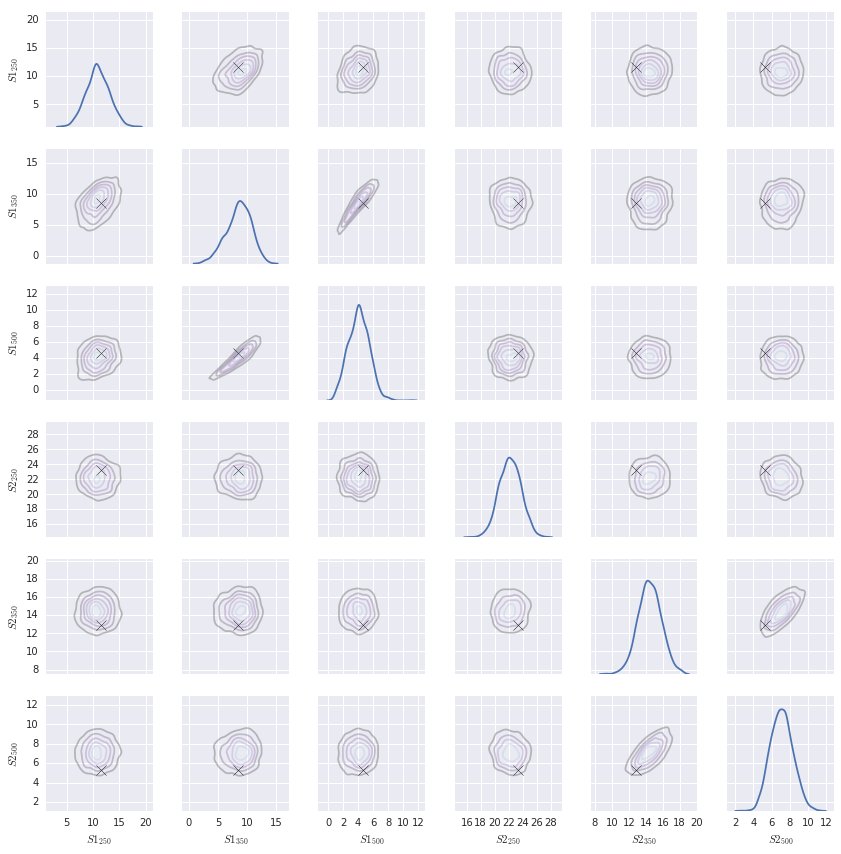

In [74]:
s1=30
s2=12
df = pd.DataFrame(posterior.stan_fit[:,:,[s1,s1+prior250.nsrc+1,s1+((prior250.nsrc+1)*2),s2,s2+prior250.nsrc+1,s2+((prior250.nsrc+1)*2)]].reshape(2000,6),columns=[r'$S1_{250}$',r'$S1_{350}$',r'$S1_{500}$',r'$S2_{250}$',r'$S2_{350}$',r'$S2_{500}$'])
g = sns.PairGrid(df,size=2)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="BuPu_d",n_levels=6,alpha=0.3)
df2 = pd.DataFrame(np.tile([fcat[prior250.ID-1].S250[s1],fcat[prior250.ID-1].S350[s1],fcat[prior250.ID-1].S500[s1],fcat[prior250.ID-1].S250[s2],fcat[prior250.ID-1].S350[s2],fcat[prior250.ID-1].S500[s2]],(2,1)),columns=[r'$S1_{250}$',r'$S1_{350}$',r'$S1_{500}$',r'$S2_{250}$',r'$S2_{350}$',r'$S2_{500}$'])
g.data=df2
g.map_offdiag(plt.scatter,marker='x', c='k', s=100,alpha=1)
g.data=pd.DataFrame(posterior_prior.stan_fit[:,:,[s1,s1+prior250.nsrc+1,s1+((prior250.nsrc+1)*2),s2,s2+prior250.nsrc+1,s2+((prior250.nsrc+1)*2)]].reshape(2000,6),columns=[r'$S1_{250}$',r'$S1_{350}$',r'$S1_{500}$',r'$S2_{250}$',r'$S2_{350}$',r'$S2_{500}$'])
g.map_diag(sns.kdeplot,c='r')
g.map_offdiag(sns.kdeplot, cmap="OrRd_d",shade=True, n_levels=6,alpha=0.5)
g.data=pd.DataFrame(posterior_orig.stan_fit[:,:,[s1,s1+prior250.nsrc+1,s1+((prior250.nsrc+1)*2),s2,s2+prior250.nsrc+1,s2+((prior250.nsrc+1)*2)]].reshape(2000,6),columns=[r'$S1_{250}$',r'$S1_{350}$',r'$S1_{500}$',r'$S2_{250}$',r'$S2_{350}$',r'$S2_{500}$'])
g.map_diag(sns.kdeplot,c='g')
g.map_offdiag(sns.kdeplot, cmap="GnBu", n_levels=6,alpha=0.3)


g.set(ylim=(0,30))
g.set(xlim=(0,30))
g.savefig('tri_'+str(s1)+'_'+str(s2)+'.png')

In [ ]:
print prior250.snim

In [ ]:
print redpdf

In [ ]:
s=0
df=pd.DataFrame(np.log10(posterior_noise_red.stan_fit[:,:,[s+(39*2),s+(39*2),s+39]].reshape(2000,3)/posterior_noise_red.stan_fit[:,:,[s,s+39,s]].reshape(2000,3)),columns=[r'$S_{500}/S_{250}$',r'$S_{500}/S_{350}$',r'$S_{350}/S_{250}$'])
g = sns.PairGrid(df)
g.map_diag(sns.kdeplot,c='g')
g.map_offdiag(sns.kdeplot, cmap="GnBu", n_levels=6,alpha=0.5,)


#for s in range(0,38):
s=18
g.data=pd.DataFrame(np.log10(posterior_noise_red.stan_fit[:,:,[s+(39*2),s+(39*2),s+39]].reshape(2000,3)/posterior_noise_red.stan_fit[:,:,[s,s+39,s]].reshape(2000,3)),columns=[r'$S_{500}/S_{250}$',r'$S_{500}/S_{350}$',r'$S_{350}/S_{250}$'])
g.map_diag(sns.kdeplot,c='r')
g.map_offdiag(sns.kdeplot, cmap='Reds', n_levels=6,alpha=0.5)
g.set(ylim=(-1,0.5))
g.set(xlim=(-1,0.5))
g.data=pd.DataFrame(np.log10(np.array([col_berta[2,:,0]/col_berta[0,:,0],col_berta[2,:,0]/col_berta[1,:,0],col_berta[1,:,0]/col_berta[0,:,0]])).T,columns=[r'$S_{500}/S_{250}$',r'$S_{500}/S_{350}$',r'$S_{350}/S_{250}$'])
g.map_offdiag(plt.scatter,c=red)
g.data=pd.DataFrame(np.log10(np.array([col_berta[2,:,1]/col_berta[0,:,1],col_berta[2,:,1]/col_berta[1,:,1],col_berta[1,:,1]/col_berta[0,:,1]])).T,columns=[r'$S_{500}/S_{250}$',r'$S_{500}/S_{350}$',r'$S_{350}/S_{250}$'])
g.map_offdiag(plt.scatter,c=red)


In [ ]:
i=16
plt.figure()
plt.plot(SEDs[[i,i+20,i+40],0])
plt.plot(SEDs[[i,i+20,i+40],1])

In [31]:
for s in range(0,prior250.nsrc):
    print s,fcat[prior250.ID-1].S250[s],fcat[prior250.ID-1].S350[s],fcat[prior250.ID-1].S500[s],prior250.sra[s],prior250.sdec[s]

0 2.16779 1.17713 0.472704 149.887786591 1.61116782754
1 0.959006 0.552979 0.231008 149.941131637 1.65894589344
2 4.44385 2.17459 0.831727 149.950580598 1.64950321902
3 7.68235 6.7518 4.21911 149.946690578 1.64728088759
4 4.77359 3.63828 1.90195 149.941135059 1.6306154829
5 2.00785 1.68857 0.944515 149.94503034 1.58784299675
6 2.13096 1.49419 0.731067 149.930579927 1.59895147473
7 1.97316 1.49318 0.775999 149.933914402 1.59839629087
8 0.317651 0.213813 0.102879 149.941135327 1.62839350182
9 2.12629 1.71406 1.07185 149.933912239 1.61561649631
10 0.175878 0.107018 0.0467147 149.897790758 1.60505855858
11 1.85129 1.05815 0.443957 149.893344376 1.60839100496
12 23.3043 12.8759 5.30945 149.913903666 1.6295018906
13 2.48547 2.3178 1.54058 149.920579858 1.57562011824
14 6.28704 7.37095 5.78204 149.9583668 1.59784287139
15 4.63581 4.579 3.00397 149.947256245 1.56229091264
16 6.31779 3.85261 1.8696 149.942253953 1.56895627895
17 0.495229 0.348343 0.198164 149.927804933 1.57062144891
18 11.6533 

In [ ]:
print prior250.nsrc

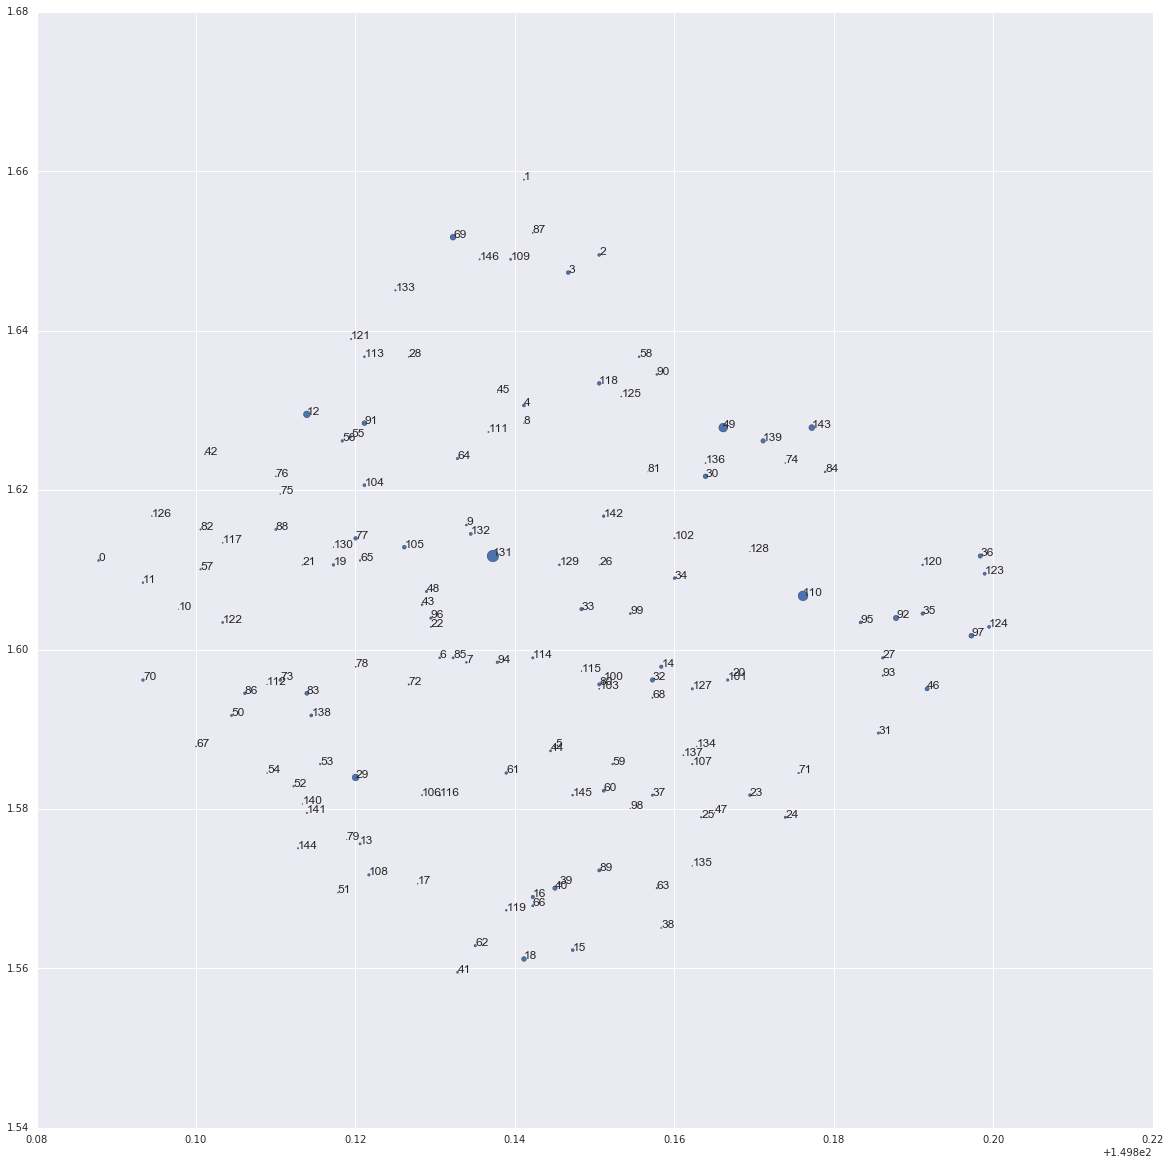

In [33]:
plt.figure(figsize=(20,20))
plt.scatter(prior250.sra,prior250.sdec,s=fcat[prior250.ID-1].S250*2)

for i in range(0,prior250.nsrc):
    plt.annotate(str(i), xy = (prior250.sra[i],prior250.sdec[i]), xytext = (0, 0), textcoords = 'offset points')

In [27]:
from xidplus import posterior_maps as maps

In [28]:
real_map=np.empty((np.max(prior250.sx_pix)-np.min(prior250.sx_pix),np.max(prior250.sy_pix)-np.min(prior250.sy_pix)))
real_map[:,:]=0.0
mod_map=np.empty((real_map.shape[0],real_map.shape[1],500))
model_map=np.empty((real_map.shape[0],real_map.shape[1],500))

mod_map_array=np.empty((prior250.snpix,500))
mod_map[:,:,:]=0
model_map[:,:,:]=0

real_map[prior250.sx_pix-np.min(prior250.sx_pix)-1,prior250.sy_pix-np.min(prior250.sy_pix)-1]=prior250.sim
print mod_map.shape
for i in range(0,500):
    mod_map_array[:,i]= maps.ymod_map(prior250,posterior.stan_fit[i,0,0:prior250.nsrc]).reshape(-1)+posterior.stan_fit[i,0,prior250.nsrc]+np.random.normal(scale=np.sqrt(prior250.snim**2+posterior.stan_fit[i,0,(prior250.nsrc+1)*3]**2))
    model_map[prior250.sx_pix-np.min(prior250.sx_pix)-1,prior250.sy_pix-np.min(prior250.sy_pix)-1,i]=maps.ymod_map(prior250,posterior.stan_fit[i,0,0:prior250.nsrc]).reshape(-1)+posterior.stan_fit[i,0,prior250.nsrc]
         
    mod_map[prior250.sx_pix-np.min(prior250.sx_pix)-1,prior250.sy_pix-np.min(prior250.sy_pix)-1,i]=mod_map_array[:,i]

(77, 65, 500)


In [61]:
real_map=np.empty((np.max(prior350.sx_pix)-np.min(prior350.sx_pix),np.max(prior350.sy_pix)-np.min(prior350.sy_pix)))
real_map[:,:]=0.0
mod_map=np.empty((real_map.shape[0],real_map.shape[1],500))
model_map=np.empty((real_map.shape[0],real_map.shape[1],500))

mod_map_array=np.empty((prior350.snpix,500))
mod_map[:,:,:]=0
model_map[:,:,:]=0

real_map[prior350.sx_pix-np.min(prior350.sx_pix)-1,prior350.sy_pix-np.min(prior350.sy_pix)-1]=prior350.sim
print mod_map.shape
for i in range(0,500):
    mod_map_array[:,i]= maps.ymod_map(prior350,posterior.stan_fit[i,0,prior350.nsrc+1:2*prior350.nsrc+1]).reshape(-1)+posterior.stan_fit[i,0,2*prior350.nsrc+1]+np.random.normal(scale=np.sqrt(prior350.snim**2+posterior.stan_fit[i,0,1+(prior350.nsrc+1)*3]**2))
    model_map[prior350.sx_pix-np.min(prior350.sx_pix)-1,prior350.sy_pix-np.min(prior350.sy_pix)-1,i]=maps.ymod_map(prior350,posterior.stan_fit[i,0,prior350.nsrc+1:2*prior350.nsrc+1]).reshape(-1)+posterior.stan_fit[i,0,2*prior350.nsrc+1]
         
    mod_map[prior350.sx_pix-np.min(prior350.sx_pix)-1,prior350.sy_pix-np.min(prior350.sy_pix)-1,i]=mod_map_array[:,i]

(56, 47, 500)


In [63]:
real_map=np.empty((np.max(prior500.sx_pix)-np.min(prior500.sx_pix),np.max(prior500.sy_pix)-np.min(prior500.sy_pix)))
real_map[:,:]=0.0
mod_map=np.empty((real_map.shape[0],real_map.shape[1],500))
model_map=np.empty((real_map.shape[0],real_map.shape[1],500))

mod_map_array=np.empty((prior500.snpix,500))
mod_map[:,:,:]=0
model_map[:,:,:]=0

real_map[prior500.sx_pix-np.min(prior500.sx_pix)-1,prior500.sy_pix-np.min(prior500.sy_pix)-1]=prior500.sim
print mod_map.shape
for i in range(0,500):
    mod_map_array[:,i]= maps.ymod_map(prior500,posterior.stan_fit[i,0,2*prior500.nsrc+2:3*prior350.nsrc+2]).reshape(-1)+posterior.stan_fit[i,0,3*prior500.nsrc+2]+np.random.normal(scale=np.sqrt(prior500.snim**2+posterior.stan_fit[i,0,2+(prior500.nsrc+1)*3]**2))
    model_map[prior500.sx_pix-np.min(prior500.sx_pix)-1,prior500.sy_pix-np.min(prior500.sy_pix)-1,i]=maps.ymod_map(prior500,posterior.stan_fit[i,0,2*prior500.nsrc+2:3*prior350.nsrc+2]).reshape(-1)+posterior.stan_fit[i,0,3*prior500.nsrc+2]
         
    mod_map[prior500.sx_pix-np.min(prior500.sx_pix)-1,prior500.sy_pix-np.min(prior500.sy_pix)-1,i]=mod_map_array[:,i]

(38, 32, 500)


In [29]:
from tempfile import NamedTemporaryFile
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)
from matplotlib import animation
from IPython.display import HTML


def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [30]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10,10))
ax2=plt.subplot(1,1,1)
res= ax2.imshow(real_map,vmin=-10,vmax=10,interpolation='nearest',cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True))
fig.colorbar(res, ax=ax2)# initialization function: plot the background of each frame
def init():
    res.set_array(real_map)
    return [res]

# animation function.  This is called sequentially
def animate(i):
    res.set_array(real_map-model_map[:,:,i])
    return [res]
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=1000, blit=True)

#anim.save('test_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

# call our new function to display the animation
display_animation(anim)

In [62]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10,10))
ax2=plt.subplot(1,1,1)
res= ax2.imshow(real_map,vmin=-10,vmax=10,interpolation='nearest',cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True))
fig.colorbar(res, ax=ax2)# initialization function: plot the background of each frame
ax2.scatter(prior350.sy-np.min(prior350.sy_pix)-1,prior350.sx-np.min(prior350.sx_pix)-1,s=fcat[prior250.ID-1].S350*2)

for i in range(0,prior250.nsrc):
    plt.annotate(str(i), xy = (prior350.sy[i]-np.min(prior350.sy_pix)-1,prior350.sx[i]-np.min(prior350.sx_pix)-1), xytext = (0, 0), textcoords = 'offset points')
def init():
    res.set_array(real_map)
    return [res]

# animation function.  This is called sequentially
def animate(i):
    res.set_array(real_map-model_map[:,:,i])
    return [res]
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=1000, blit=True)

#anim.save('test_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

# call our new function to display the animation
display_animation(anim)

In [64]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10,10))
ax2=plt.subplot(1,1,1)
res= ax2.imshow(real_map,vmin=-10,vmax=10,interpolation='nearest',cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True))
fig.colorbar(res, ax=ax2)# initialization function: plot the background of each frame
ax2.scatter(prior500.sy-np.min(prior500.sy_pix)-1,prior500.sx-np.min(prior500.sx_pix)-1,s=fcat[prior250.ID-1].S500*2)

for i in range(0,prior250.nsrc):
    plt.annotate(str(i), xy = (prior500.sy[i]-np.min(prior500.sy_pix)-1,prior500.sx[i]-np.min(prior500.sx_pix)-1), xytext = (0, 0), textcoords = 'offset points')
def init():
    res.set_array(real_map)
    return [res]

# animation function.  This is called sequentially
def animate(i):
    res.set_array(real_map-model_map[:,:,i])
    return [res]
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=1000, blit=True)

#anim.save('test_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

# call our new function to display the animation
display_animation(anim)

In [ ]:
fig = plt.figure(figsize=(20,20))
ax2=plt.subplot(1,1,1)
res= ax2.imshow(real_map,vmin=-8,vmax=100,interpolation='nearest')
# initialization function: plot the background of each frame

In [ ]:
prior250.moc.plot()
plt.plot(prior250.sra,prior250.sdec, 'bo')

In [ ]:
print prior250.snim[:]

In [ ]:
from scipy.stats import norm
rv = norm()
np.log10(rv.cdf(np.arange(-5,5,0.5))-rv.cdf(-10))

(array([  14.,   48.,  199.,  332.,  525.,  445.,  271.,  122.,   38.,    6.]),
 array([-4.25173773, -4.1762037 , -4.10066968, -4.02513565, -3.94960163,
        -3.87406761, -3.79853358, -3.72299956, -3.64746554, -3.57193151,
        -3.49639749]),
 <a list of 10 Patch objects>)

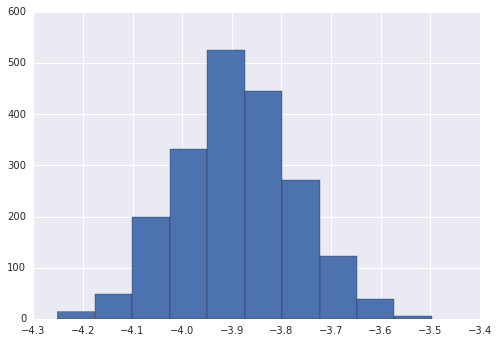

In [60]:
plt.hist(posterior.stan_fit[:,:,[2*prior250.nsrc+1]].reshape(2000,1))

In [ ]:
print posterior.n_eff

In [ ]:
prior250.moc.write('moc_spm_test')

In [78]:
outfile=output_folder+'Lacy_test_file_'+str(tiles[taskid-1])+'_'+str(order)+'.pkl'
with open(outfile, 'wb') as f:
   pickle.dump({'psw':prior250,'pmw':prior350,'plw':prior500,'posterior':posterior_orig},f)